In [1]:
import builtins
from tqdm import tqdm

In [2]:
# Output path
output_path = '../export/simulators/emotional_trader/'

In [4]:
# Run the input processing notebook to prepare input
%run "../helpers/data-processing.ipynb"

Missing values in the dataset


,Column,Missing Count,Missing Percentage,Action
0,date,0,0.000000,No Missing Values
1,open,0,0.000000,No Missing Values
2,high,0,0.000000,No Missing Values
3,low,0,0.000000,No Missing Values
4,close,0,0.000000,No Missing Values
5,Volume USDT,0,0.000000,No Missing Values
6,tradecount,0,0.000000,No Missing Values
7,ema_5,0,0.000000,No Missing Values
8,ema_15,0,0.000000,No Missing Values
9,ema_30,0,0.000000,No Missing Values



Dropped features with correlation higher than 90%: {'ema_15', 'Z-Score', 'ema_60', 'ema_200', 'WMA', 'ema_100', 'ema_30', 'MACD_Hist', 'KAMA', 'HMA', 'ema_5'}

Shape of X: (1997210, 12)


,date,price,Volume USDT,tradecount,MACD,MACD_Signal,ATR,CMO,QStick,price_change_ratio,trade_volume_ratio,high_low_spread
0,1.577837e+09,7180.720,509146.0,140.0,0.728704,-0.152219,4.684925,4.193879,0.120,0.000000,3636.757143,0.000
1,1.577837e+09,7178.470,713540.0,148.0,0.736887,-0.182091,4.698380,0.859360,0.528,-0.000313,4821.216216,-2.250
2,1.577837e+09,7179.440,497793.0,104.0,0.846578,-0.117923,4.609025,11.466626,0.493,0.000135,4786.471154,0.970
3,1.577837e+09,7177.175,698627.0,193.0,0.650488,-0.343494,4.398181,-7.962104,-0.425,-0.000315,3619.829016,-2.265
4,1.577837e+09,7175.160,241980.0,124.0,0.987398,-0.092457,4.262656,-6.795307,-0.131,-0.000281,1951.451613,-2.015
...,...,...,...,...,...,...,...,...,...,...,...,...
1997205,1.698019e+09,29966.285,482950.0,635.0,-4056.925846,-1909.922487,926.278065,-97.689989,13.189,-0.000401,760.551181,-12.020
1997206,1.698019e+09,29970.500,169682.0,450.0,-3657.565528,-1988.042791,996.882531,-97.688910,24.399,0.000141,377.071111,4.215
1997207,1.698019e+09,29975.100,111271.0,303.0,-3095.229187,-1922.717147,1072.856572,-97.688328,32.045,0.000153,367.231023,4.600
1997208,1.698019e+09,29980.890,169741.0,631.0,-2332.807178,-1640.974425,1154.492462,-97.687019,22.669,0.000193,269.003170,5.790



Shape of y: (1997210,)


,price_direction
0,1
1,0
2,1
3,0
4,0


In [5]:
# Convert `X` and `y` back to a DataFrame for easier manipulation
features = pd.DataFrame(X, columns=features.columns)  # Features from preprocessing
target = pd.Series(y, name="price_direction")         # Target column

In [6]:
# Ensure the features and target align
prices = features['price'].values
predictions = target.values        # Binary predictions from target

In [7]:
# Parameters
rolling_window = 14  # Rolling window for metrics
buy_fee = 0.0025  # 0.25% buy fee
sell_fee = 0.004  # 0.40% sell fee

In [8]:
# Calculate rolling metrics using only prior input
rolling_mean = pd.Series(prices).rolling(window=rolling_window, min_periods=1).mean().values
rolling_std = pd.Series(prices).rolling(window=rolling_window, min_periods=1).std().fillna(0).values
momentum = prices - rolling_mean  # Positive or negative trend

In [9]:
# Adjust probabilities based on current and prior input
P_buy = 0.5 + 0.3 * (momentum > 0)  # Higher buy probability for positive momentum
P_sell = 0.5 + 0.3 * (momentum < 0)  # Higher sell probability for negative momentum

In [10]:
# Normalize probabilities so they sum to 1
total_probs = P_buy + P_sell
P_buy /= total_probs
P_sell /= total_probs

In [11]:
# Initialize portfolio values
initial_capital = 10000.0  # USD
usd_balance = initial_capital  # Start with all USD
btc_balance = 0.0  # Start with no BTC

In [12]:
# Tracking Variables
actions = []
trade_percentages = []
usd_balances = []
btc_balances = []

In [13]:
# Iterate through each row to simulate trades with tqdm for progress tracking
for i in tqdm(range(len(prices)), desc="Simulating Trades", unit="trade"):
    # Set default action and trade percentage
    action = 'None'
    trade_percentage = 0.0

    # Skip early rows where rolling metrics aren't available
    if i < rolling_window:
        usd_balances.append(usd_balance)
        btc_balances.append(btc_balance)
        actions.append(action)
        trade_percentages.append(trade_percentage)
        continue

    # Use rolling metrics within the defined rolling window
    mean_price = rolling_mean[i - rolling_window:i].mean() if i >= rolling_window else rolling_mean[i]
    std_price = rolling_std[i - rolling_window:i].std() if i >= rolling_window else rolling_std[i]

    # Determine trade action and percentage
    if P_buy[i] > P_sell[i] and usd_balance > 0:
        # Buy decision
        trade_percentage = min(0.1 * P_buy[i], usd_balance / prices[i])
        usd_spent = trade_percentage * usd_balance
        btc_bought = (usd_spent * (1 - buy_fee)) / prices[i]  # Deduct fees
        usd_balance -= usd_spent
        btc_balance += btc_bought
        action = 'Buy'
    elif P_sell[i] > P_buy[i] and btc_balance > 0:
        # Sell decision
        trade_percentage = min(0.1 * P_sell[i], btc_balance)
        btc_to_sell = trade_percentage * btc_balance
        usd_gained = btc_to_sell * prices[i] * (1 - sell_fee)  # Deduct fees
        btc_balance -= btc_to_sell
        usd_balance += usd_gained
        action = 'Sell'

    # Record balances and actions
    usd_balances.append(usd_balance)
    btc_balances.append(btc_balance)
    actions.append(action)
    trade_percentages.append(trade_percentage)

Simulating Trades: 100%|██████████| 1997210/1997210 [00:21<00:00, 93538.17trade/s]


In [14]:
# Ensure all arrays have consistent length with `prices`
assert len(actions) == len(prices)
assert len(trade_percentages) == len(prices)
assert len(usd_balances) == len(prices)
assert len(btc_balances) == len(prices)

In [15]:
# Export results
builtins.data = monte_carlo_df = pd.DataFrame({
    'prices': prices,  # Use real price input
    'rolling_mean': rolling_mean,
    'rolling_volatility': rolling_std,
    'momentum': momentum,
    'P_buy': P_buy,
    'P_sell': P_sell,
    'Action': actions,
    'Trade_Percentage': trade_percentages,
    'USD_Balance': usd_balances,
    'BTC_Balance': btc_balances
})

Trading Log:


,prices,rolling_mean,rolling_volatility,momentum,P_buy,P_sell,Action,Trade_Percentage,USD_Balance,BTC_Balance,Total_Capital
0,7180.720,7180.720000,0.000000,0.000000,0.500000,0.500000,None,0.000000,10000.000000,0.000000,10000.000000
1,7178.470,7179.595000,1.590990,-1.125000,0.384615,0.615385,None,0.000000,10000.000000,0.000000,10000.000000
2,7179.440,7179.543333,1.128554,-0.103333,0.384615,0.615385,None,0.000000,10000.000000,0.000000,10000.000000
3,7177.175,7178.951250,1.500446,-1.776250,0.384615,0.615385,None,0.000000,10000.000000,0.000000,10000.000000
4,7175.160,7178.193000,2.136169,-3.033000,0.384615,0.615385,None,0.000000,10000.000000,0.000000,10000.000000
...,...,...,...,...,...,...,...,...,...,...,...
1997205,29966.285,29987.638214,12.001177,-21.353214,0.384615,0.615385,Sell,0.000307,8.871985,0.000307,18.083552
1997206,29970.500,29986.761071,12.805384,-16.261071,0.384615,0.615385,Sell,0.000307,8.874806,0.000307,18.084836
1997207,29975.100,29986.462143,13.040027,-11.362143,0.384615,0.615385,Sell,0.000307,8.877625,0.000307,18.086238
1997208,29980.890,29985.833571,13.084484,-4.943571,0.384615,0.615385,Sell,0.000307,8.880443,0.000307,18.088006


Processing Rows: 100%|██████████| 1997210/1997210 [00:39<00:00, 50964.90rows/s]


Final Portfolio Status:
  USD Balance: $0.00
  BTC Balance: 0.001511 BTC
  BTC Value (in USD at last price): $45.32
  Total Portfolio Value (USD): $45.32
  Profit/Loss: -99.55%
  Total Trades Executed: 557985
    Buy Trades: 306884
    Sell Trades: 251101


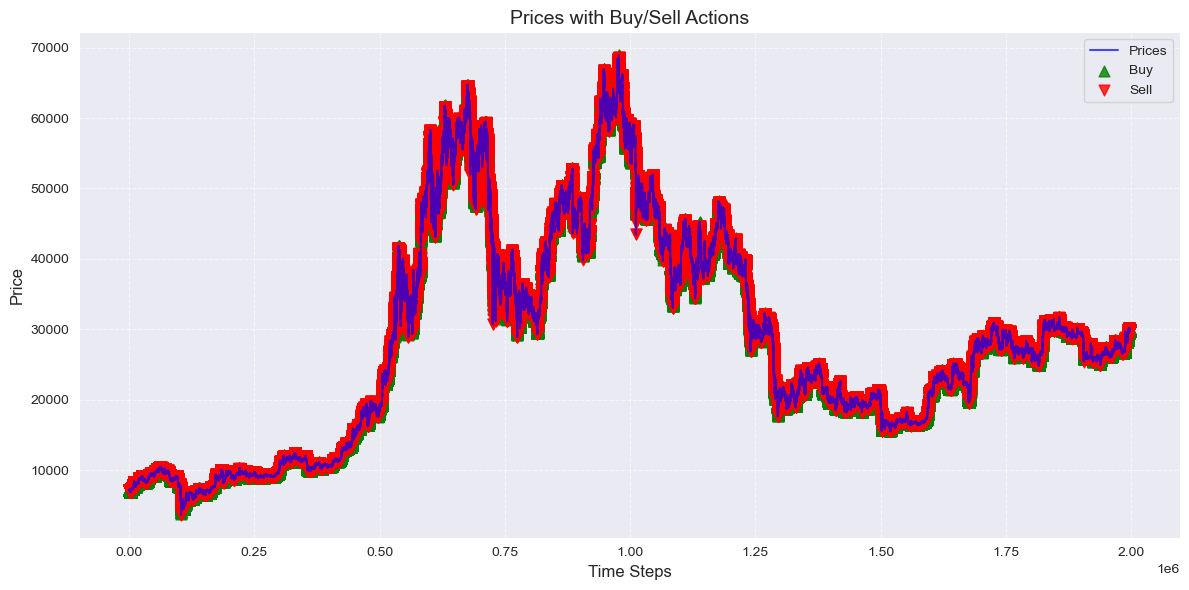

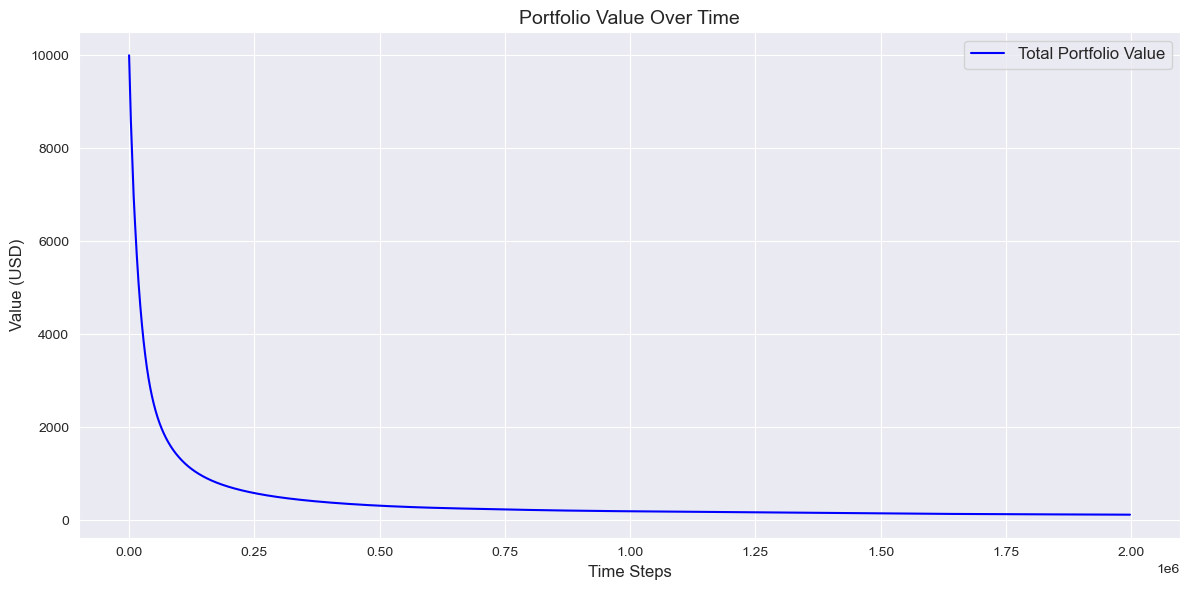

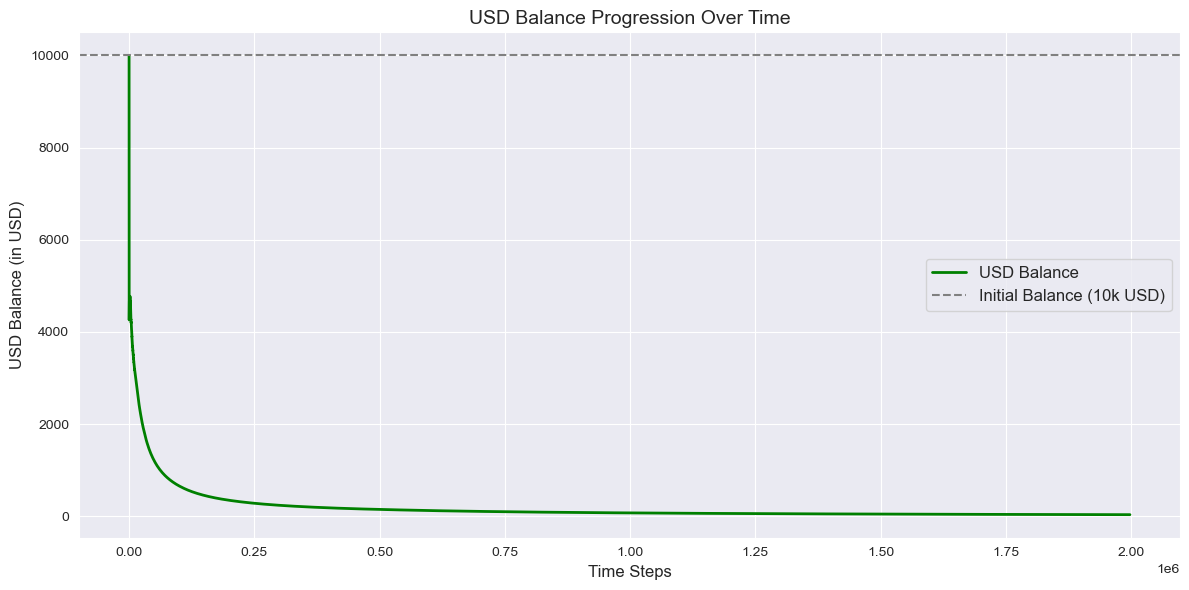

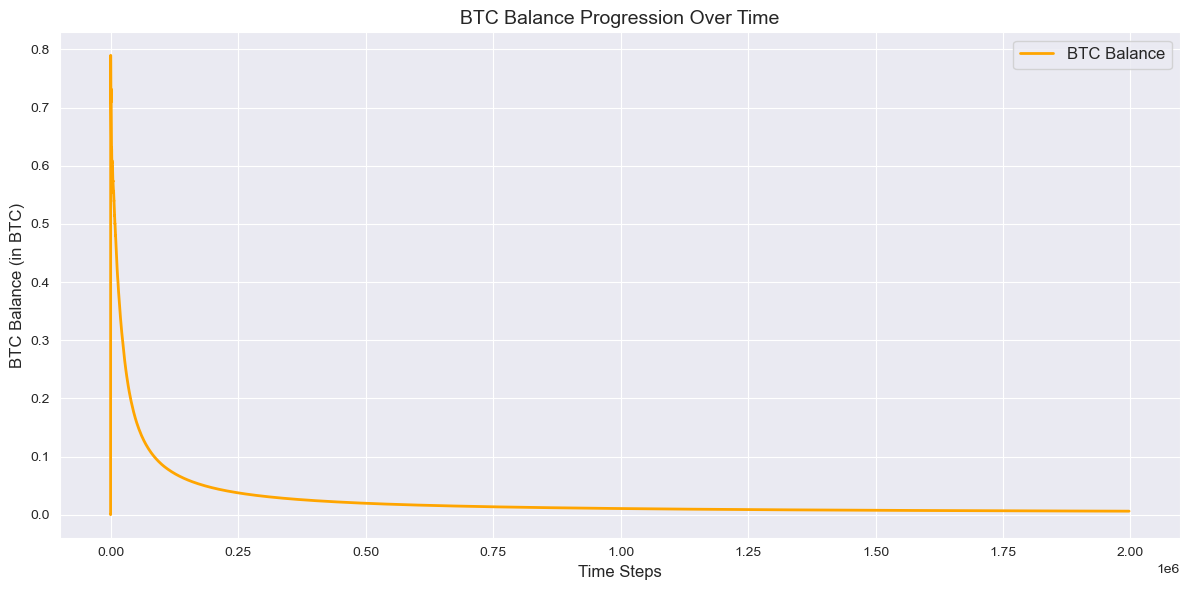

In [17]:
%run "../helpers/trades.ipynb"

Data Leakage Check

Data alignment check passed.
Correlation between predictions and future price changes:
                     predictions  future_price_change
predictions             1.000000             0.250137
future_price_change     0.250137             1.000000


Feature Importance Analysis

Feature Importances:
               Feature  Importance
9   price_change_ratio    0.516161
11     high_low_spread    0.476724
8               QStick    0.004632
7                  CMO    0.001428
5          MACD_Signal    0.000667
4                 MACD    0.000188
2          Volume USDT    0.000079
6                  ATR    0.000045
3           tradecount    0.000031
0                 date    0.000016
1                price    0.000016
10  trade_volume_ratio    0.000012
Permutation Importances:
               Feature  Importance
9   price_change_ratio    0.392866
11     high_low_spread    0.103024
0                 date    0.000000
1                price    0.000000
2          Volume USDT  

Processing Rows: 100%|██████████| 1997210/1997210 [00:39<00:00, 50099.46rows/s]

Processing Rows: 100%|██████████| 1997210/1997210 [00:48<00:00, 40934.28rows/s]

Processing Rows: 100%|██████████| 1997210/1997210 [00:53<00:00, 37218.79rows/s]

Processing Rows: 100%|██████████| 1997210/1997210 [00:40<00:00, 49656.25rows/s]

Processing Rows: 100%|██████████| 1997210/1997210 [00:39<00:00, 50707.02rows/s]

Processing Rows: 100%|██████████| 1997210/1997210 [00:40<00:00, 49663.94rows/s]

Testing Initial Balances: 100%|██████████| 3/3 [06:34<00:00, 131.56s/it]



Sensitivity Analysis



,Initial USD Balance,Initial BTC Balance,Maker Fee,Taker Fee,Final USD Balance,Final BTC Balance,Total Portfolio Value (USD),Profit/Loss (%),Buy Trades,Sell Trades
0,10000.0,0.0,0.0025,0.0040,0.001419,0.001511,45.317639,-99.546824,306884,251101
1,10000.0,0.0,0.0015,0.0030,66.550256,0.003309,165.797321,-98.342027,1004375,977323
2,10000.0,0.0,0.0050,0.0075,0.000201,0.000175,5.258268,-99.947417,82173,60115
3,20000.0,0.0,0.0025,0.0040,0.002048,0.001976,59.263961,-99.703680,684708,310041
4,20000.0,0.0,0.0015,0.0030,163.559313,0.005659,333.277110,-98.333614,1004375,992624
5,20000.0,0.0,0.0050,0.0075,0.000229,0.000224,6.709079,-99.966455,91726,71290
6,5000.0,0.5,0.0025,0.0040,0.001419,0.001416,42.469351,-99.150613,300586,244055
7,5000.0,0.5,0.0015,0.0030,43.502023,0.003279,141.826643,-97.163467,1004375,935905
8,5000.0,0.5,0.0050,0.0075,0.000168,0.000166,4.981365,-99.900373,78775,57632


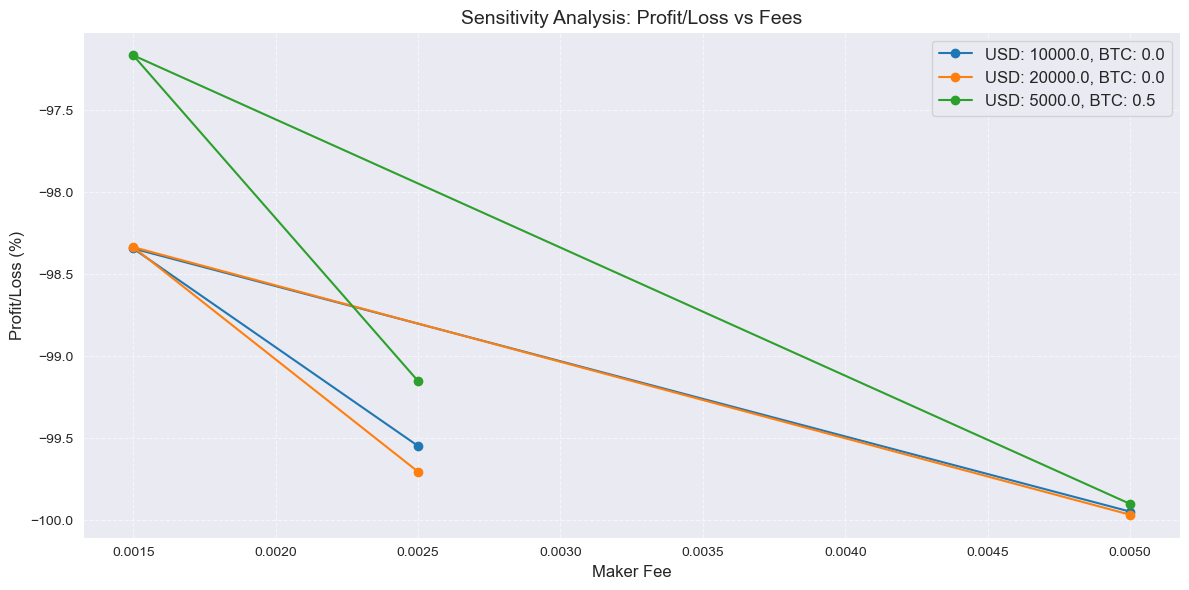

In [19]:
%run "../helpers/testing.ipynb"